In [30]:
import os, sys
import numpy as np
import json
from addict import Dict
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import scipy.stats as stats
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize
from baobab.configs import *
from h0rton.configs import TrainValConfig, TestConfig
from baobab.data_augmentation.noise_lenstronomy import NoiseModelNumpy

import glob
import matplotlib.image as mpimg
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Plotting params
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='STIXGeneral', size=20)
plt.rc('xtick', labelsize='medium')
plt.rc('ytick', labelsize='medium')
plt.rc('text', usetex=True)
plt.rc('axes', linewidth=2, titlesize='large', labelsize='large')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
baobab_cfg = BaobabConfig.from_file('/home/jwp/stage/sl/h0rton/baobab_configs/v7/test_v7_baobab_config.py')
meta = pd.read_csv(os.path.abspath(os.path.join(baobab_cfg.out_dir, 'metadata.csv')), index_col=None)

img_files = [fname for fname in os.listdir(baobab_cfg.out_dir) if fname.endswith('.npy')]

In [3]:
default_version_id = 2 #12
default_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(default_version_id)
test_cfg_path = os.path.join(default_version_dir, 'mcmc_default.json')
test_cfg = TestConfig.from_file(test_cfg_path)
train_val_cfg = TrainValConfig.from_file(test_cfg.train_val_config_file_path)
noise_kwargs_default = train_val_cfg.data.noise_kwargs.copy()

In [4]:
summary = pd.read_csv(os.path.join(default_version_dir, 'summary.csv'), index_col=False, nrows=200)
metadata = pd.read_csv(os.path.join(baobab_cfg.out_dir, 'metadata.csv'), index_col=False)
metadata['id'] = metadata.index

In [7]:
summary.columns, summary.shape, metadata.shape

(Index(['Unnamed: 0', 'n_img', 'z_lens', 'z_src', 'id', 'D_dt_mu', 'D_dt_sigma',
        'H0_mean', 'H0_std', 'inference_time', 'D_dt_mean', 'D_dt_std', 'H0',
        'agn_light_magnitude', 'external_shear_dec_0',
        'external_shear_gamma_ext', 'external_shear_psi_ext',
        'external_shear_ra_0', 'img_filename', 'kappa_ext',
        'lens_light_R_sersic', 'lens_light_center_x', 'lens_light_center_y',
        'lens_light_e1', 'lens_light_e2', 'lens_light_magnitude',
        'lens_light_n_sersic', 'lens_mass_center_x', 'lens_mass_center_y',
        'lens_mass_e1', 'lens_mass_e2', 'lens_mass_gamma', 'lens_mass_theta_E',
        'lensed_total_flux_TDLMC_F160W', 'magnification',
        'measured_magnification', 'n_img_meta', 'src_light_R_sersic',
        'src_light_center_x', 'src_light_center_y', 'src_light_e1',
        'src_light_e2', 'src_light_magnitude', 'src_light_n_sersic',
        'total_magnification_TDLMC_F160W', 'true_td', 'true_vd',
        'unlensed_total_flux_TDLMC_F

In [6]:
summary = summary.merge(metadata, on='id', suffixes=['', '_meta'], how='inner')

# 1. Gallery of test-set examples

## Get the total flux of the lensed ring

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LightModel.light_model import LightModel
from lenstronomy.PointSource.point_source import PointSource

from lenstronomy.ImSim.image_model import ImageModel
import lenstronomy.Util.util as util
import lenstronomy.Util.data_util as data_util

from baobab.sim_utils import Imager, Selection, get_PSF_model
from baobab.sim_utils import flux_utils, metadata_utils
from baobab.configs import BaobabConfig

In [9]:
summary['lensed_E_ring_flux'] = 0.0
summary['lensed_E_ring_mag'] = 0.0
#summary.drop([200], inplace=True)

In [10]:
lens_mass_model = LensModel(lens_model_list=['PEMD', 'SHEAR_GAMMA_PSI'])
src_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
lens_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
ps_model = PointSource(point_source_type_list=['LENSED_POSITION'], fixed_magnification_list=[False])
components = ['lens_mass', 'src_light', 'agn_light', 'lens_light']
bp = baobab_cfg.survey_info.bandpass_list[0] # only one bandpass
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs = survey_object.kwargs_single_band()
# Factor of effective exptime relative to exptime of the noiseless images
exposure_time_factor = np.ones([1, 1, 1]) 
exposure_time_factor[0, :, :] = train_val_cfg.data.eff_exposure_time[bp]/noise_kwargs['exposure_time']

noise_kwargs.update(exposure_time=train_val_cfg.data.eff_exposure_time[bp])
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs)

for lens_i in range(200):
    imager = Imager(components, lens_mass_model, src_light_model, lens_light_model=lens_light_model, ps_model=ps_model, kwargs_numerics={'supersampling_factor': 1}, min_magnification=0.0, for_cosmography=True)
    imager._set_sim_api(num_pix=64, kwargs_detector=noise_kwargs, psf_kernel_size=survey_object.psf_kernel_size, which_psf_maps=survey_object.which_psf_maps)
    imager.kwargs_src_light = [metadata_utils.get_kwargs_src_light(metadata.iloc[lens_i])]
    imager.kwargs_src_light = flux_utils.mag_to_amp_extended(imager.kwargs_src_light, imager.src_light_model, imager.data_api)
    imager.kwargs_lens_mass = metadata_utils.get_kwargs_lens_mass(metadata.iloc[lens_i])
    sample_ps = metadata_utils.get_nested_ps(metadata.iloc[lens_i])
    imager.for_cosmography = False
    imager._load_agn_light_kwargs(sample_ps)
    lensed_total_flux, lensed_src_img = flux_utils.get_lensed_total_flux(imager.kwargs_lens_mass, imager.kwargs_src_light, None, imager.image_model, return_image=True)
    lensed_ring_total_flux = np.sum(lensed_src_img)
    summary.loc[lens_i, 'lensed_E_ring_flux'] = lensed_ring_total_flux
    summary.loc[lens_i, 'lensed_E_ring_mag'] = data_util.cps2magnitude(lensed_ring_total_flux, noise_kwargs['magnitude_zero_point'])

## Bin the Einstein ring brightness

In [15]:
lensed_ring_bins = np.quantile(summary['lensed_E_ring_mag'].values, [0.25, 0.5, 0.75, 1])
print(lensed_ring_bins)
print(np.digitize([18, 20, 21, 22], lensed_ring_bins)[:5])
summary['lensed_ring_bin'] = np.digitize(summary['lensed_E_ring_mag'].values, lensed_ring_bins)

[19.10677816 20.33934623 21.62941189 22.8300621 ]
[0 1 2 3]


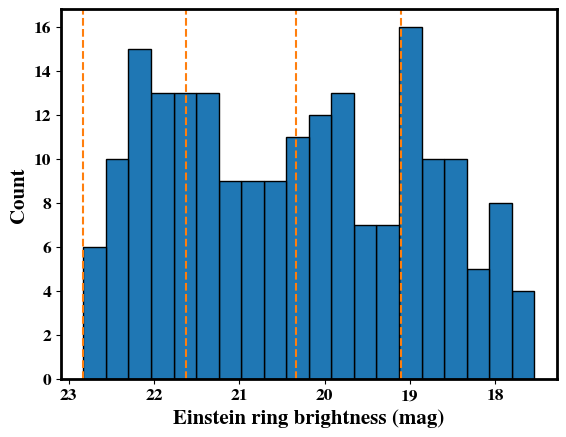

In [16]:
plt.close('all')
plt.hist(summary['lensed_E_ring_mag'], edgecolor='k', bins=20)
plt.gca().invert_xaxis()
for bin_edge in lensed_ring_bins:
    plt.axvline(bin_edge, color='tab:orange', linestyle='--')
plt.xlabel('Einstein ring brightness (mag)')
plt.ylabel('Count')
plt.show()

# Visualize training set images

In [26]:

from astropy.visualization import (MinMaxInterval, AsinhStretch, SqrtStretch, LinearStretch,
                                   ImageNormalize)


In [27]:
n_test = 200
prec_version_dir = '/home/jwp/stage/sl/h0rton/experiments/v{:d}'.format(0)
prec_summary = pd.read_csv(os.path.join(prec_version_dir, 'ering_summary.csv'), index_col=None, nrows=n_test)
summary['lensed_E_ring_mag'] = prec_summary['lensed_E_ring_mag'].values
lensed_ring_bins = np.quantile(summary['lensed_E_ring_mag'].values, [0.25, 0.5, 0.75, 1])
lensed_ring_bins[-1] += 0.1 # buffer 
summary['lensed_ring_bin'] = np.digitize(summary['lensed_E_ring_mag'].values, lensed_ring_bins)

In [28]:
summary[['id', 'lensed_E_ring_mag', 'lensed_ring_bin', 'n_img']].values

array([[138.        ,  20.63680769,   2.        ,   2.        ],
       [ 10.        ,  21.24103543,   2.        ,   4.        ],
       [  3.        ,  18.10822915,   0.        ,   2.        ],
       [ 63.        ,  19.60115265,   1.        ,   4.        ],
       [ 69.        ,  18.08806068,   0.        ,   2.        ],
       [191.        ,  22.05906044,   3.        ,   2.        ],
       [186.        ,  19.12585453,   1.        ,   4.        ],
       [167.        ,  21.79764234,   3.        ,   4.        ],
       [ 74.        ,  19.70387712,   1.        ,   2.        ],
       [ 30.        ,  20.12912854,   1.        ,   2.        ],
       [127.        ,  21.48445947,   2.        ,   4.        ],
       [ 66.        ,  21.56667368,   2.        ,   2.        ],
       [179.        ,  22.83012596,   3.        ,   4.        ],
       [  8.        ,  18.19059902,   0.        ,   2.        ],
       [ 55.        ,  22.34219205,   3.        ,   4.        ],
       [143.        ,  22

{'read_noise': 4, 'pixel_scale': 0.08, 'ccd_gain': 2.5, 'exposure_time': 5400.0, 'sky_brightness': 22.0, 'magnitude_zero_point': 25.9463, 'num_exposures': 1, 'seeing': None, 'psf_type': 'PIXEL'}
10800.0
0.00016625420803689783 3.282053670293058
0.0031796401671840956 11.366146110996247
-0.001208123881483926 11.651912329629505
-0.0006698141473275082 49.042785564392865
0.006590753740634632 13.09290544466438
0.00021760393453490413 33.71733029337439
0.0039736501664404174 13.415676655525433
0.00684116630275418 23.886565500856303
0.003579315439285822 6.51214671992429
0.015922489720232292 22.70230692573337
0.004775253942020472 23.383926313752465
0.004863067015804605 98.23319023972165
0.01824327474860561 26.265590716101926
0.001180033396577294 67.41333692434173
0.011935700478148587 26.911007958595132
0.0231495714466962 47.79945938543018
0.010777233123814766 13.062697796836371
0.030151114686338257 45.45443674103623
0.013469214446356986 46.73733208781286
0.012142650788310089 196.38972561765115
0.0

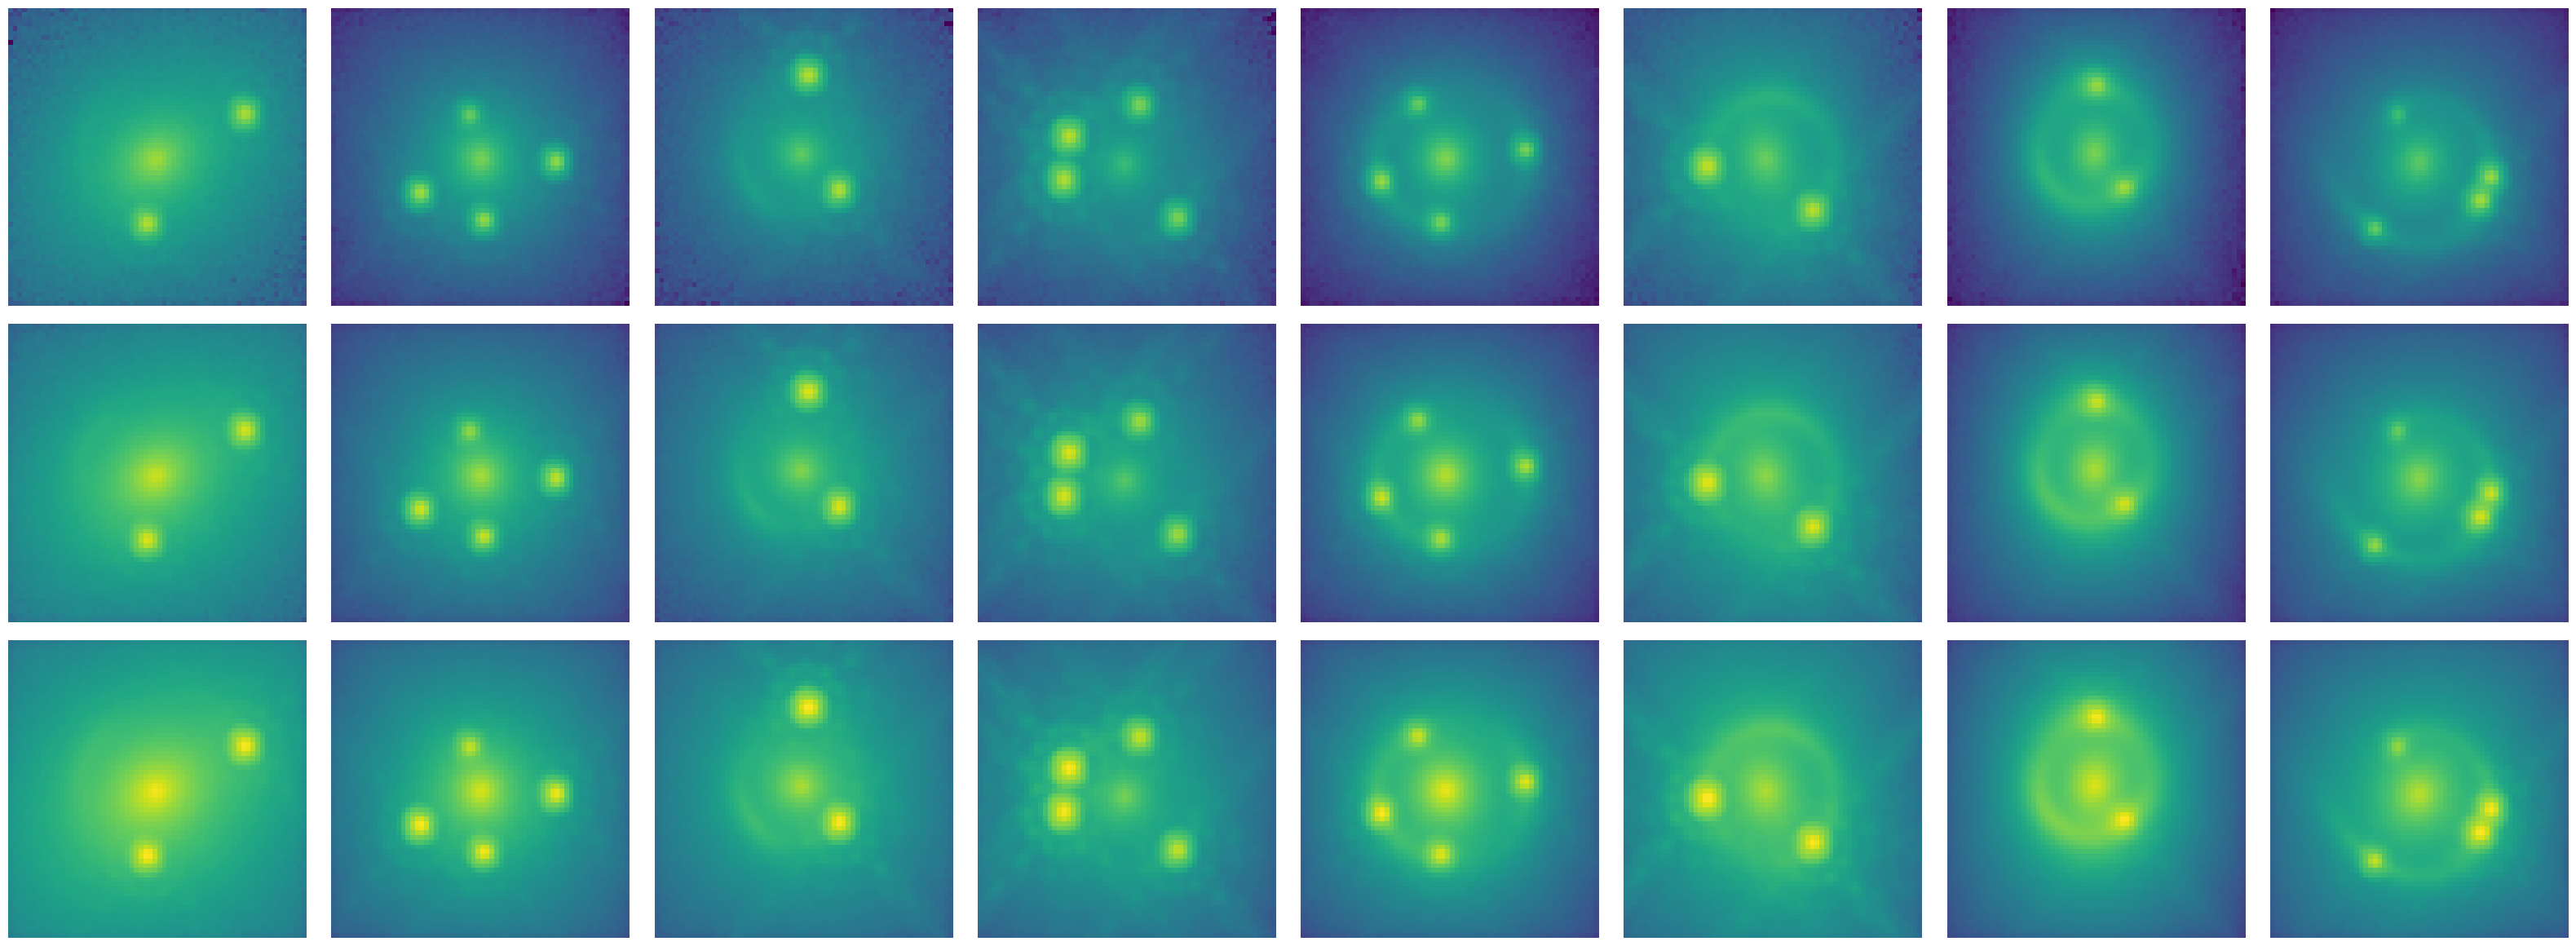

In [31]:
n_rows = 3
n_cols = 8
n_img = n_rows*n_cols

plt.close('all')
#imgs = []
#for img_file in img_files[:n_img]:
#    img_path = os.path.join(baobab_cfg.out_dir, img_file)
#    imgs.append(np.load(img_path))

fig = plt.figure(figsize=(32, 12))
imgs_per_row = n_img//n_rows
#imgs = imgs[:imgs_per_row]*4
ax = []

bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = 1#np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
print(noise_kwargs_default)
# Factor of effective exptime relative to exptime of the noiseless images
print(train_val_cfg.data.eff_exposure_time[bp])
noise_kwargs_default.update(exposure_time=5400.0)
# Dictionary of noise models
noise_model = NoiseModelNumpy(**noise_kwargs_default)

orig_img_ids = [181, 4, 39, 199, 58, 56, 186, 184][::-1]
#orig_img_ids = [43, 4]
distinct_lenses = len(orig_img_ids)
#img_ids = orig_img_ids*4

img_dict = {} # will be populated as a nested dict, img[img_id][exp_factor]
for i, img_id in enumerate(orig_img_ids):
    img_dict[img_id] = {}
    for exp_i, exp_factor in enumerate([0.5, 1.0, 2.0]):
        noise_kwargs_default.update(exposure_time=5400*exp_factor)
        noise_model = NoiseModelNumpy(**noise_kwargs_default)
        img = np.load(os.path.join(baobab_cfg.out_dir, 'X_{0:07d}.npy'.format(img_id)))
        img *= exp_factor
        noise_map = noise_model.get_noise_map(img)
        img += noise_map
        img_dict[img_id][exp_factor] = img

vmin_dict = {}
vmax_dict = {}
for i, img_id in enumerate(orig_img_ids):
    # Get the min/max pixel value in images across exposure times
    min_pixel_vals = [np.min(lens_image[lens_image > 0]) for lens_image in [img_dict[img_id][exp_factor] for exp_factor in [0.5, 1.0, 2.0]]]
    max_pixel_vals = [np.max(lens_image) for lens_image in [img_dict[img_id][exp_factor] for exp_factor in [0.5, 1.0, 2.0]]]
    vmin_dict[img_id] = min(min_pixel_vals) #max(min(min_pixel_vals), 1.e-4)
    vmax_dict[img_id] = max(max_pixel_vals)
    
for i in range(n_cols*n_rows):
    #plt.subplot(n_rows, n_cols, i+1)
    #print(img_id, i // n_cols, noise_map[0, :5, 0])
    img_id = orig_img_ids[i%n_cols]
    exp_factor = [0.5, 1.0, 2.0][i//n_cols]
    
    #img = np.log1p(img)
    #print(np.min(img), np.max(img))
    #img = (img - np.min(img))/(np.max(img) - np.min(img))#img = (img - img.mean())/img.std()
    #img = np.log(img)
    #img = (img - np.mean(img))/np.std(img)
    img = img_dict[img_id][exp_factor]
    img = np.squeeze(img)
    print(np.min(img), np.max(img))
    
    # create subplot and append to ax
    fig.add_subplot(n_rows, n_cols, i+1)
    #print(exposure_time_factor[0, 0, 0], np.min(img), np.max(img))
    #plt.imshow(img, origin='lower', vmin=0, vmax=5, cmap='viridis', norm=None)
    img[img < 0] = vmin_dict[img_id]
    plt.imshow(img, origin='lower', norm=LogNorm(), vmin=vmin_dict[img_id], vmax=vmax_dict[img_id], cmap='viridis')
    plt.axis('off')
plt.tight_layout()
plt.savefig('../training_set_gallery_fully_transformed.png', bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

# Simple gallery of all test set images

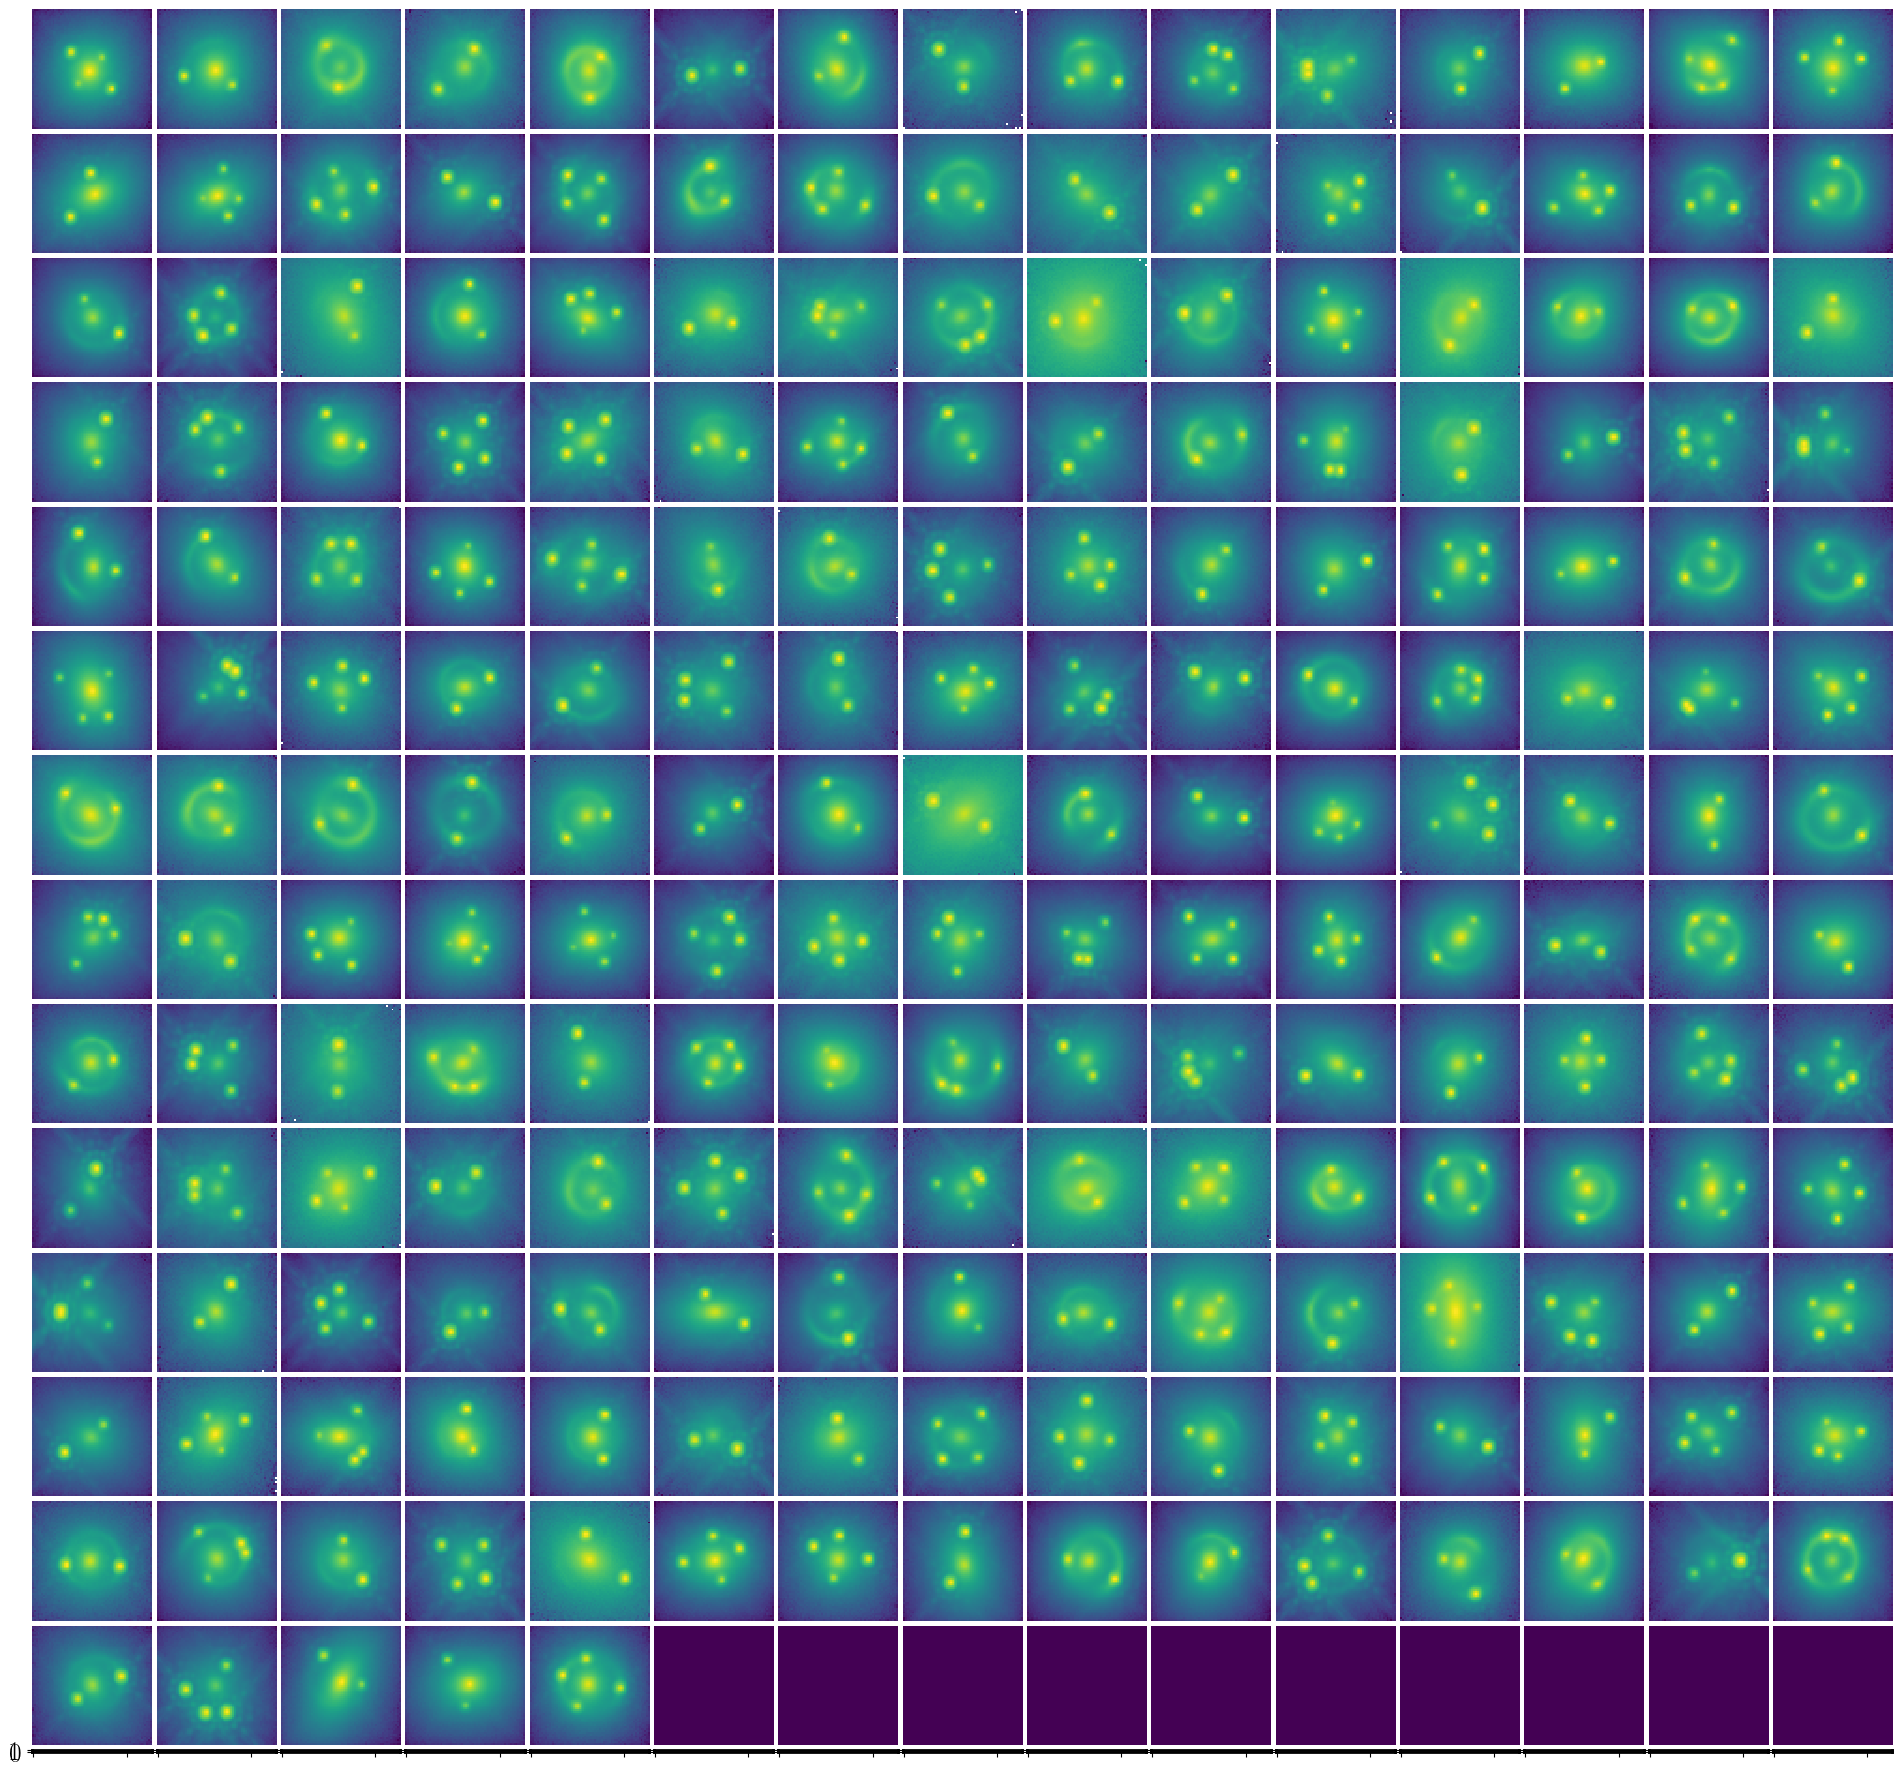

In [44]:
bp = baobab_cfg.survey_info.bandpass_list[0]
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
# Factor of effective exptime relative to exptime of the noiseless images
exp_factor = 0.5

imgs = [] # will be populated as a nested dict, img[img_id][exp_factor]
for i, img_id in enumerate(np.arange(200)):
    noise_kwargs_default.update(exposure_time=5400.0*exp_factor)
    noise_model = NoiseModelNumpy(**noise_kwargs_default)
    img = np.load(os.path.join(baobab_cfg.out_dir, 'X_{0:07d}.npy'.format(img_id)))
    img *= exp_factor
    noise_map = noise_model.get_noise_map(img)
    img += noise_map
    imgs.append(img.squeeze())

for pad in range(10):
    imgs.append(np.ones((64, 64))*1.e-7)
    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

plt.close('all')
fig = plt.figure(figsize=(24, 24))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(15, 15),  # creates 2x2 grid of axes
                 axes_pad=0.05,  # pad between axes in inch.
                 )

for ax, im in zip(grid, imgs):
    # Iterating over the grid returns the Axes.
    ax.imshow(im, norm=LogNorm())
    ax.axis('off')
    ax.set_xticklabels([])
plt.axis('off') # didn't work for the lowermost x axis
cur_axes = plt.gca()
cur_axes.axes.get_xaxis().set_visible(False)
cur_axes.axes.get_yaxis().set_visible(False)
plt.show()

# 2. Compute SNR without lens light (excluding lens light from signal)

In [208]:
bp = baobab_cfg.survey_info.bandpass_list[0]
exposure_time_factor = 1#np.ones([1, 1, 1]) 
survey_object = baobab_cfg.survey_object_dict[bp]
# Dictionary of SingleBand kwargs
noise_kwargs_default = survey_object.kwargs_single_band()
noise_kwargs_default.update(exposure_time=5400.0)
print(noise_kwargs_default)

lens_mass_model = LensModel(lens_model_list=['PEMD', 'SHEAR_GAMMA_PSI'])
src_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
lens_light_model = LightModel(light_model_list=['SERSIC_ELLIPSE'])
ps_model = PointSource(point_source_type_list=['LENSED_POSITION'], fixed_magnification_list=[False])
components = ['lens_mass', 'src_light', 'agn_light', ] 

snr_dict_no_lens = {} # will be populated as a nested dict, img[img_id][exp_factor]
snr_summary_dict_no_lens = {}
for exp_i, exp_factor in enumerate([0.5, 1.0, 2.0]):
    snr_dict_no_lens[exp_factor] = []
    for i, lens_i in enumerate(np.arange(200)):
        noise_kwargs_default.update(exposure_time=5400*exp_factor)
        noise_model = NoiseModelNumpy(**noise_kwargs_default)
        
        imager = Imager(components, lens_mass_model, src_light_model, lens_light_model=lens_light_model, ps_model=ps_model, kwargs_numerics={'supersampling_factor': 1}, min_magnification=0.0, for_cosmography=True)
        imager._set_sim_api(num_pix=64, kwargs_detector=noise_kwargs_default, psf_kernel_size=99, which_psf_maps=[101])
        imager.kwargs_src_light = [metadata_utils.get_kwargs_src_light(metadata.iloc[lens_i])]
        imager.kwargs_src_light = flux_utils.mag_to_amp_extended(imager.kwargs_src_light, imager.src_light_model, imager.data_api)
        imager.kwargs_lens_mass = metadata_utils.get_kwargs_lens_mass(metadata.iloc[lens_i])
        sample_ps = [metadata_utils.get_kwargs_ps_lensed(metadata.iloc[lens_i])]
        imager.for_cosmography = False
        imager._load_agn_light_kwargs(metadata_utils.get_nested_ps(metadata.iloc[lens_i]))
        lensed_total_flux, img = flux_utils.get_lensed_total_flux(imager.kwargs_lens_mass, imager.kwargs_src_light, None, imager.image_model, return_image=True)
        lensed_ring_total_flux = np.sum(img)
        img *= exp_factor
        noise_map = np.abs(noise_model.get_noise_map(img))
        img += noise_map
        #print("Sum of noise: ", np.sum(noise_map))
        if False:
            print(np.sum(noise_map))
            plt.imshow(img)
            plt.colorbar()
            plt.show()
        snr_no_lens_per_pixel = np.median(img/noise_map)
        snr_no_lens = np.sum(img)/np.sum(noise_map)
        snr_dict_no_lens[exp_factor].append((snr_no_lens_per_pixel, snr_no_lens))
    snr_summary_dict_no_lens[exp_factor] = (np.median(snr_dict_no_lens[exp_factor][0]), np.median(snr_dict_no_lens[exp_factor][1]))
    print(snr_summary_dict_no_lens[exp_factor])


{'read_noise': 4, 'pixel_scale': 0.08, 'ccd_gain': 2.5, 'exposure_time': 5400.0, 'sky_brightness': 22.0, 'magnitude_zero_point': 25.9463, 'num_exposures': 1, 'seeing': None, 'psf_type': 'PIXEL'}
(6.654231470485542, 4.511979155356323)
(16.01307462727918, 10.268616113843029)
(37.71569653402311, 23.889467040095113)


# 3. Illustrate the importance of D_dt fit distribution

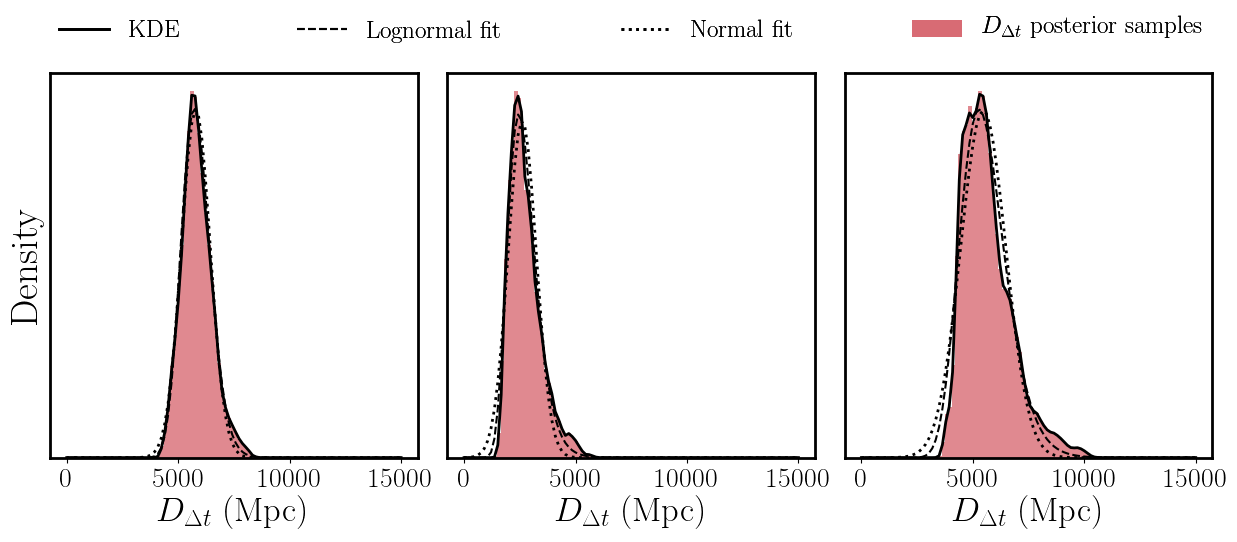

In [31]:
from h0rton.h0_inference import plotting_utils, h0_utils
from scipy.stats import norm, gaussian_kde
plt.close('all')
# Plot a D_dt histogram for the pipeline diagram
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, lens_i in enumerate([ 20, 169, 31,]):
    saved_dict = np.load('/home/jwp/stage/sl/h0rton/experiments/v2/mcmc_default/D_dt_dict_{0:04}.npy'.format(lens_i), allow_pickle=True).item()
    uncorrected_D_dt_samples = saved_dict['D_dt_samples']
    oversampling = 20
    uncorrected_D_dt_samples = h0_utils.remove_outliers_from_lognormal(uncorrected_D_dt_samples, 3).reshape(-1, 1) # [n_samples, 1] 
    k_ext_rv = getattr(stats, test_cfg.kappa_ext_prior.dist)(**test_cfg.kappa_ext_prior.kwargs)
    k_ext = k_ext_rv.rvs(size=[len(uncorrected_D_dt_samples), oversampling]) # [n_samples, oversampling]
    if test_cfg.kappa_ext_prior.transformed:
        #print("Transformed")
        D_dt_samples = (uncorrected_D_dt_samples*k_ext).flatten()
        #print(D_dt_samples.shape)
    else:
        D_dt_samples = (uncorrected_D_dt_samples/(1.0 - k_ext)).flatten() # [n_samples,]
        
    D_dt_grid = np.linspace(0, 15000, 100)
    # Plot KDE
    kde = gaussian_kde(D_dt_samples, bw_method='scott')
    axes[i].plot(D_dt_grid, kde(D_dt_grid), color='k', linestyle='solid', label='KDE', linewidth=2)
    # Plot lognormal fit
    D_dt_stats = h0_utils.get_lognormal_stats(D_dt_samples)
    axes[i].plot(D_dt_grid, plotting_utils.lognormal(D_dt_grid, D_dt_stats['mu'], D_dt_stats['sigma']), color='k', linestyle='dashed', label='Lognormal fit')
    # Plot normal fit
    D_dt_stats_normal = h0_utils.get_normal_stats(D_dt_samples)
    axes[i].plot(D_dt_grid, norm.pdf(D_dt_grid, loc=D_dt_stats_normal['mean'], scale=D_dt_stats_normal['std']), color='k', ls='dotted', label='Normal fit', linewidth=2)
    # Plot samples
    axes[i].hist(D_dt_samples, range=[0, 15000], bins=100, color='#d6616b', density=True, label='$D_{\Delta t}$ posterior samples', alpha=0.75)
    #plt.axvline(saved_dict['true_D_dt'], c='tab:gray', ls='--', label='True $D_{\Delta t}$')
    axes[i].set_yticks([])
    axes[i].set_xlabel('$D_{\Delta t}$ (Mpc)', fontsize=25)
    #axes[i].set_ylabel('Density', fontsize=25)
    #plt.xticks([0, 15000], [0, 15000], fontsize=20)
global_legend = axes[0].legend(bbox_to_anchor=(0.03, 1.03, 2 + 1.1, 0.102), loc='upper center', ncol=4, mode="expand", borderaxespad=-0.5, fontsize=18, frameon=False, columnspacing=0.08)

axes[0].add_artist(global_legend)
axes[0].set_ylabel('Density', fontsize=28)
plt.subplots_adjust(wspace=0.08)

plt.show()
fig.savefig('../kde_vs_lognormal_vs_normal.png', bbox_inches='tight', pad_inches=0)